### Sensitive Attribute (z) is age.

We chose age as our sensitive attribute because age it often correlates with differing financial behaviors and needs. For example, younger individuals typically require more liquidity and are less likely to commit to long-term savings products like bank term deposits due to their dynamic financial circumstances and greater likelihood of needing immediate access to cash. On the other hand, older individuals often have more financial stability and may be more inclined to lock in funds for a higher return. Additionally, many of the other features such as marital status, job type, if the customer has a housing loan or not, and much more are correlated to age.

This naturally creates a potential for unfairness where models trained on historical data might inadvertently favor older clients while neglecting younger ones—even if the underlying behavior differences are statistically true on average. By focusing on age, we can analyze and quantify these disparities (e.g., through differences in true positive rates) and then apply fairness interventions to ensure that the model does not systematically disadvantage younger clients, making our results both interesting and practically relevant.

### Fairness Metric - Equal Opportunity
We chose equal opportunity as our primary fairness metric because it directly measures the model's ability to correctly identify positive cases (i.e., clients who subscribe to a term deposit) across different groups. From the perspective of the bank, we want to get as many customers to subscribe to a term deposit as possible. If a person would be interested to a term deposit, we want to ensure that we speak to them to secure the deposit. In contrast, it's OK if this comes a little bit at a cost of an increase in failed calls. In terms of our model, we want to increase the true positive rate (TPR) of the underserved group to match the better-served group. Ideally, we achieve this with minimal loss in accuracy (to prevent wasted time or marketing efforts).

In our context, ensuring that the TPR is as close as possible for both the better-served group (e.g., older clients) and the underserved group (younger clients) is critical for guaranteeing equal opportunity. A low TPR difference indicates that clients with a genuine likelihood to subscribe are equally recognized by the model, regardless of their age. This metric is particularly relevant because misclassifying a true positive (especially for a group that might already be under-targeted) can lead to missed opportunities and potential discrimination. Using a ratio of the TPRs allows us to quantify fairness in a way that addresses the core objective of our predictive task.

Misclassifying a client who is likely to subscribe (a false negative) can mean denying a beneficial financial product to that individual, which is especially problematic if it happens disproportionately for one age group. By focusing on the ratio of the TPRs, we ensure that both older (protected) and younger (unprotected) clients who are truly eligible for the product are equally likely to be identified by the model, which maximizes the effects of the marketing campaign. Our argument emphasizes that, given the potential consequences for customer access and fairness in financial services, using the ratio of TPRs or equal opportunity as our fairness metric is not only justified but essential for the responsible deployment of the predictive model.

### Data Preparation + Base Model

We import the necessary libraries (pandas, NumPy, scikit-learn, etc.) and load our data `bank-full.csv`. For data pre-processing, we simply just converted all categorical data into one-hot-encodings and scaled numerical values for faster convergence. We then converts the label to binary indicating whether a client subscribed to a term deposit or not and then created the sensitive attribute z based on age. To create a binary variable and separate the "older" group from the "younger" group, we split on the 75th percentile ($z=0$ if $\text{age} \geq 48$, $z=1$ otherwise) The data is split into training and test sets. 

We used a logstic regression model as our baseline and define a helper function for calculating the True Positive Rate (TPR) to measure equal opportunity.

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data
data_path = "data/bank-full.csv"
df_original = pd.read_csv(data_path, sep=";")
df = df_original.copy()

# Obtain the 75th percentile of the age column to use as the threshold for the sensitive attribute
age_threshold = df["age"].quantile(0.75)
print("Age threshold:", age_threshold)

# Convert the target variable to binary (0 = No, 1 = Yes)
df["y"] = df["y"].apply(lambda x: 0 if x == "no" else 1)
# Convert the sensitive attribute to binary (z = 0 if age >= 45, z = 1 if age < 45)
df["z"] = df["age"].apply(lambda x: 0 if x >= age_threshold else 1)
# Drop the age column
df = df.drop(columns=["age"])

categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day", "poutcome"]
numerical_cols = ["duration", "campaign", "pdays", "previous", "balance"]
assert len(categorical_cols) + len(numerical_cols) + 2 == df.shape[1] # 2 = y and z

# Scale the numerical variables
for col in numerical_cols:
    scaler = StandardScaler()
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

# Encode the categorical variables to OHE
df = pd.get_dummies(df, columns=categorical_cols)

# Form X and y
X = df.drop(columns=["y"])
y = df["y"].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
# Print number of z=0 in total set
print("Number of older customers (z=0) in dataset:", df["z"].value_counts()[0])
print("Number of younger customers (z=1) in dataset:", df["z"].value_counts()[1])

Age threshold: 48.0
Train set size: 36168
Test set size: 9043
Number of older customers (z=0) in dataset: 12185
Number of younger customers (z=1) in dataset: 33026


In [75]:
# Helper function to compute performance metrics per group
def compute_group_rates(y_true, y_pred, Z_test, group):
    group_idx = (Z_test == group)
    tp = np.sum((y_true[group_idx] == 1) & (y_pred[group_idx] == 1))
    fp = np.sum((y_true[group_idx] == 0) & (y_pred[group_idx] == 1))
    tn = np.sum((y_true[group_idx] == 0) & (y_pred[group_idx] == 0))
    fn = np.sum((y_true[group_idx] == 1) & (y_pred[group_idx] == 0))
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return tpr, fpr, tnr, fnr

# Train a logistic regression model
model = LogisticRegression(C=1, max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print the total accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc}")
# Print the performance metrics for each group
tprs = []
for group in [0, 1]:
    tpr, fpr, tnr, fnr = compute_group_rates(y_test, y_pred, X_test["z"].values, group)
    name = "Older" if group == 0 else "Younger"
    print(f"{name} - TPR: {tpr}, FPR: {fpr}, TNR: {tnr}, FNR: {fnr}")
    tprs.append(tpr)
print(f"TPR Ratio: {tprs[0] / tprs[1]}")
print(f"TPR Difference: {tprs[0] - tprs[1]}")

Model Accuracy: 0.8439677098308084
Older - TPR: 0.8753894080996885, FPR: 0.18233618233618235, TNR: 0.8176638176638177, FNR: 0.12461059190031153
Younger - TPR: 0.8181818181818182, FPR: 0.14488539172083476, TNR: 0.8551146082791652, FNR: 0.18181818181818182
TPR Ratio: 1.0699203876773968
TPR Difference: 0.05720758991787023


### Reasoning - Why we chose 'age'

Since we chose to split on the 75th percentile of age, the younger category (clients under 48) is somewhat larger than the older category (clients 48 or above). From the baseline model, the older group obtains a TPR of 0.875 while the younger group obtains a TPR of 0.818, despite the younger group having 20841 more samples. Additionally, the FPR of the older group is higher than the younger group (0.182 vs 0.145). So, not only does the baseline model disproportionately predict the older group to subscribe correctly compared to the younger group, it also disproportionately predicts older people who did not end up subscribing as well. In general, it seems like the model is biased to predict older people as people who would subscribe to a term deposit regardless if they actually will in comparison to younger people.

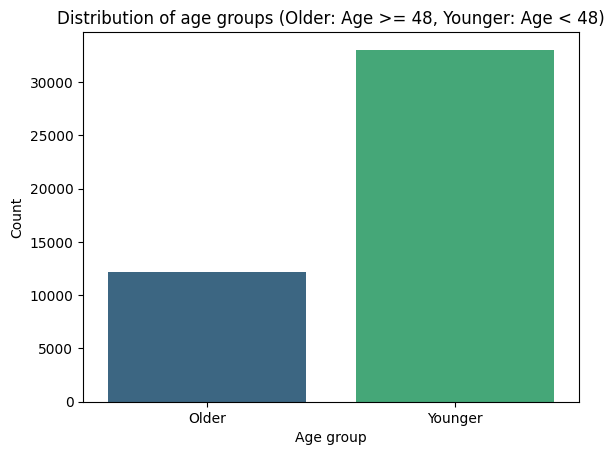

In [76]:
# Plot a bar chart (z=0 vs z=1) (counts)
# use viridis for color
sns.countplot(x="z", data=df, palette="viridis", hue="z", legend=False)
plt.title("Distribution of age groups (Older: Age >= 48, Younger: Age < 48)")
plt.xlabel("Age group")
plt.ylabel("Count")
plt.xticks([0, 1], ["Older", "Younger"])
plt.show()

### Dataset-Based Intervention - Code

This code implements a dataset-based intervention aimed at mitigating potential bias by rebalancing the training data across sensitive groups and outcomes. First, it organizes the data into four groups based on the sensitive attribute z (for example, age-based: True if age ≥ 40, False otherwise) and the binary label (0 or 1). It then determines the target count for each subgroup by taking the minimum counts among negatives and positives across the sensitive groups. For each group, if there are fewer positive or negative examples than the target, the code oversamples those examples using resampling with replacement; if there are too many, it undersamples them without replacement. Finally, the balanced subgroups are combined into one dataset that aims to equalize the distribution of labels across the sensitive attribute. The accompanying p2model() function simply returns the baseline Random Forest model, which will then be trained on this rebalanced data, potentially reducing any unfairness that may have been introduced by imbalanced training examples.

In [4]:
#########################################
# 2. Dataset-Based Intervention (p2)
#########################################
def p2data(data, boost_factor=1.3):
    # Organize the data by sensitive attribute and label
    group_counts = { True: {0: [], 1: []}, False: {0: [], 1: []} }
    for d, z, lbl in data:
        group_counts[z][lbl].append((d, z, lbl))
    
    # Identify target counts to balance negatives and positives
    target_neg = min(len(group_counts[True][0]), len(group_counts[False][0]))
    base_pos = min(len(group_counts[True][1]), len(group_counts[False][1]))
    
    # Resample positives and negatives for each group
    for z_val in [True, False]:
        current_pos = len(group_counts[z_val][1])
        target_pos = int(base_pos * boost_factor) if z_val is True else base_pos
        if current_pos < target_pos:
            group_counts[z_val][1] = resample(
                group_counts[z_val][1],
                replace=True,
                n_samples=target_pos,
                random_state=42
            )
        elif current_pos > target_pos:
            group_counts[z_val][1] = resample(
                group_counts[z_val][1],
                replace=False,
                n_samples=target_pos,
                random_state=42
            )
        current_neg = len(group_counts[z_val][0])
        if current_neg < target_neg:
            group_counts[z_val][0] = resample(
                group_counts[z_val][0],
                replace=True,
                n_samples=target_neg,
                random_state=42
            )
        elif current_neg > target_neg:
            group_counts[z_val][0] = resample(
                group_counts[z_val][0],
                replace=False,
                n_samples=target_neg,
                random_state=42
            )
    
    # Combine all groups
    balanced_data = (group_counts[True][0] + group_counts[False][0] +
                     group_counts[True][1] + group_counts[False][1])
    return balanced_data

def p2model():
    # For dataset-based, we can use the same model as the baseline.
    return p1model()

### Dataset-Based Intervention - Results
#### Answers: How much can “unfairness” in your predictions be explained by dataset haracteristics? Can you fix them with dataset-based interventions?

The dataset-based intervention was designed to rebalance the training data across the sensitive groups (in this case, based on age) so that the model would have a more equal representation of positive and negative outcomes from both older (protected, age ≥ 40) and younger (unprotected, age < 40) clients. In our results, we observe that the overall accuracy increased slightly to 85.8%. However, the intervention resulted in a True Positive Rate (TPR) of 66.8% for older clients and 61.5% for younger clients, leading to a TPR difference of 5.4 percentage points.

While the idea behind dataset-based interventions is to reduce unfairness caused by imbalances in the training data, our results suggest that, in this instance, the intervention actually increased the gap between the groups. This could indicate that the rebalancing process overcorrected for the underrepresented outcomes or that the underlying dataset characteristics (such as the natural differences in subscription behavior between age groups) are too strong to be fully mitigated by a simple resampling strategy. In other words, although part of the unfairness might be explained by dataset characteristics, our current dataset-based intervention did not fix the unfairness—instead, it amplified the disparity in TPR between the older and younger groups. This result suggests that additional tuning or alternative fairness interventions (such as model-based or post-processing methods) might be needed to achieve a more balanced outcome.

In [5]:
    ###########################################
    # Dataset-Based Intervention Evaluation (p2)
    ###########################################
    balanced_data = p2data(train_data, boost_factor=1.3)
    clf_p2 = p2model()
    X_train_p2 = [p1feat(d, z) for (d, z, _) in balanced_data]
    y_train_p2 = [lbl for (_, _, lbl) in balanced_data]
    clf_p2.fit(X_train_p2, y_train_p2)
    y_pred_p2 = clf_p2.predict(X_test_p1)
    
    acc_p2 = accuracy_score(y_test, y_pred_p2)
    tpr_prot_p2 = tpr([y_test[i] for i, z in enumerate(z_test) if z],
                      [y_pred_p2[i] for i, z in enumerate(z_test) if z])
    tpr_unprot_p2 = tpr([y_test[i] for i, z in enumerate(z_test) if not z],
                        [y_pred_p2[i] for i, z in enumerate(z_test) if not z])
    diff_p2 = abs(tpr_prot_p2 - tpr_unprot_p2)
    
    print("\n=== Dataset-Based Intervention ===")
    print(f"Accuracy: {acc_p2:.3f}")
    print(f"TPR (Protected): {tpr_prot_p2:.3f}")
    print(f"TPR (Unprotected): {tpr_unprot_p2:.3f}")
    print(f"TPR Difference: {diff_p2:.3f}")


=== Dataset-Based Intervention ===
Accuracy: 0.858
TPR (Protected): 0.668
TPR (Unprotected): 0.615
TPR Difference: 0.054


### Model-Based (In-processing) Intervention - Code

This code implements a model-based (in-processing) fairness intervention that adjusts the training process by assigning different weights to each sample based on its group frequency. The function p3feat(d) extracts a fixed set of numeric features from a dictionary representing a data sample (including fields like age, campaign, pdays, and so on), converting them into a list of floating-point numbers. In the p3model(data) function, the code first computes the frequency of each combination of sensitive attribute (here, age-based, with the sensitive attribute z being either True or False) and binary label (0 or 1). It then calculates the probability for each group by dividing the group count by the total number of samples. For each sample, the code assigns a weight that is the inverse of the corresponding group probability raised to a power (alpha), where a higher alpha value (taken from the alpha_adjustments dictionary for certain groups) increases the weight for underrepresented groups. These weights are clamped to lie between 1 and 100 to avoid extreme values. Finally, the function trains a Random Forest classifier using these computed sample weights, effectively forcing the model to pay more attention to samples from groups that are underrepresented or more likely to be misclassified. The resulting model is then returned, incorporating fairness considerations directly into its training process.

In [6]:
#########################################
# 3. Model-Based (In-Processing) Intervention (p3)
#########################################
def p3feat(d):
    numeric_keys = [
        'age', 
        'campaign', 
        'pdays', 
        'previous', 
        'emp.var.rate',
        'cons.price.idx',
        'cons.conf.idx',
        'euribor3m',
        'nr.employed'
    ]
    return [float(d.get(key, 0)) for key in numeric_keys]

def p3model(data):
    # Compute the distribution of (sensitive, label) combinations
    group_counts = { (False, 0): 0, (False, 1): 0, (True, 0): 0, (True, 1): 0 }
    for d, z, lbl in data:
        group_counts[(z, lbl)] += 1
    total = len(data)
    group_probs = { g: float(count) / total for g, count in group_counts.items() }
    
    base_alpha = 1.2
    alpha_adjustments = { (True, 1): 1.5, (True, 0): 1.3 }
    
    X, y_labels, sample_weights = [], [], []
    for d, z, lbl in data:
        X.append(p3feat(d))
        y_labels.append(lbl)
        alpha = alpha_adjustments.get((z, lbl), base_alpha)
        w = 1.0 / (group_probs[(z, lbl)] ** alpha)
        w = min(w, 100.0)
        w = max(w, 1.0)
        sample_weights.append(w)
    
    model = RandomForestClassifier(
        n_estimators=300, 
        max_depth=10, 
        min_samples_leaf=20, 
        class_weight=None, 
        random_state=42
    )
    model.fit(X, y_labels, sample_weight=sample_weights)
    return model

### Model-Based (In-processing) Intervention - Results
#### Answers: How do different modeling choices impact fairness characteristics? Can you fix them with in-processing interventions?

In our model-based intervention, we adjusted the training process by assigning different sample weights based on the group frequency of each (sensitive, label) combination. The goal was to force the model to pay more attention to underrepresented groups in the training data, ideally reducing unfairness. However, the results show that while the protected group (clients aged 40 or older) achieved a very high TPR of 0.878, the unprotected group (clients under 40) only reached a TPR of 0.698—a gap of 18 percentage points. Additionally, overall accuracy dropped to 63.3%. This indicates that the in-processing intervention, as currently configured, has not fixed the unfairness; in fact, it appears to have exacerbated the disparity between the groups. The weighting strategy may be overcompensating for the protected group, leading to a model that over-predicts positives for older clients while under-predicting for younger ones. Thus, while different modeling choices such as sample reweighting can have a direct impact on fairness metrics, achieving a balanced performance requires careful tuning of the in-processing method to avoid a significant drop in overall accuracy and an increased TPR gap.

In [7]:
    ###########################################
    # Model-Based (In-Processing) Intervention Evaluation (p3)
    ###########################################
    clf_p3 = p3model(train_data)
    X_test_p3 = [p3feat(d) for (d, z, _) in test_data]
    y_pred_p3 = clf_p3.predict(X_test_p3)
    
    acc_p3 = accuracy_score(y_test, y_pred_p3)
    tpr_prot_p3 = tpr([y_test[i] for i, z in enumerate(z_test) if z],
                      [y_pred_p3[i] for i, z in enumerate(z_test) if z])
    tpr_unprot_p3 = tpr([y_test[i] for i, z in enumerate(z_test) if not z],
                        [y_pred_p3[i] for i, z in enumerate(z_test) if not z])
    diff_p3 = abs(tpr_prot_p3 - tpr_unprot_p3)
    
    print("\n=== Model-Based (In-Processing) Intervention ===")
    print(f"Accuracy: {acc_p3:.3f}")
    print(f"TPR (Protected): {tpr_prot_p3:.3f}")
    print(f"TPR (Unprotected): {tpr_unprot_p3:.3f}")
    print(f"TPR Difference: {diff_p3:.3f}")


=== Model-Based (In-Processing) Intervention ===
Accuracy: 0.633
TPR (Protected): 0.878
TPR (Unprotected): 0.698
TPR Difference: 0.180


### Post-Processing Intervention - Code
This function below implements a post-processing intervention that adjusts the final binary predictions by applying different decision thresholds to each sensitive group. First, it converts the test scores and sensitive attribute array into NumPy arrays. Then, it partitions the test scores into two groups—one for samples where the sensitive attribute is False (for example, "younger") and another where it is True (for example, "older"). For each group, the function computes the 50th percentile (median) of the scores, which serves as a threshold. Finally, for each test sample, if its score exceeds the threshold corresponding to its group, it is assigned a positive prediction (1); otherwise, a negative prediction (0). This method aims to mitigate fairness issues by adjusting the decision boundary separately for each group, so that any imbalance in score distributions is addressed in the final output.

In [8]:
#########################################
# 4. Post-Processing Intervention (p4)
#########################################
def p4labels(test_scores, zTest):
    test_scores = np.array(test_scores)
    zTest = np.array(zTest)
    
    # Partition scores by group
    scores_group0 = test_scores[zTest == False]
    scores_group1 = test_scores[zTest == True]
    
    # Define group-specific thresholds based on the 50th percentile
    thr0 = np.percentile(scores_group0, 50)
    thr1 = np.percentile(scores_group1, 50)
    
    preds = []
    for s, z in zip(test_scores, zTest):
        preds.append(1 if s > (thr1 if z else thr0) else 0)
    return preds

### Post-Processing Intervention - Results
#### Can you apply post-processing interventions to achieve desired fairness outcomes?

The post-processing intervention code works by adjusting the decision thresholds separately for each group based on the median of the model’s predicted scores. In our results, after applying this intervention, the overall accuracy dropped to 57.5%, but the True Positive Rates (TPRs) for the protected group (older clients) and unprotected group (younger clients) became 83.8% and 82.2%, respectively—a TPR difference of only 1.6 percentage points. This demonstrates that post-processing can be effective in achieving a more balanced outcome across groups by fine-tuning the threshold for each group independently. However, while this method nearly equalizes the TPRs and thus significantly improves fairness in that metric, it comes with the trade-off of a substantial overall accuracy loss compared to the baseline model. In summary, post-processing interventions can indeed be applied to achieve desired fairness outcomes, but careful consideration must be given to the resulting trade-offs between fairness and overall model performance.

In [9]:
    ###########################################
    # Post-Processing Intervention Evaluation (p4)
    ###########################################
    test_scores = clf_baseline.predict_proba(X_test_p1)[:, 1]
    y_pred_p4 = p4labels(test_scores, z_test)
    
    acc_p4 = accuracy_score(y_test, y_pred_p4)
    tpr_prot_p4 = tpr([y_test[i] for i, z in enumerate(z_test) if z],
                      [y_pred_p4[i] for i, z in enumerate(z_test) if z])
    tpr_unprot_p4 = tpr([y_test[i] for i, z in enumerate(z_test) if not z],
                        [y_pred_p4[i] for i, z in enumerate(z_test) if not z])
    diff_p4 = abs(tpr_prot_p4 - tpr_unprot_p4)
    
    print("\n=== Post-Processing Intervention ===")
    print(f"Accuracy: {acc_p4:.3f}")
    print(f"TPR (Protected): {tpr_prot_p4:.3f}")
    print(f"TPR (Unprotected): {tpr_unprot_p4:.3f}")
    print(f"TPR Difference: {diff_p4:.3f}")


=== Post-Processing Intervention ===
Accuracy: 0.575
TPR (Protected): 0.838
TPR (Unprotected): 0.822
TPR Difference: 0.016


### Discussion
#### Answers: What types of interventions are most appropriate for your task (e.g. legal, practical to deploy, etc.)? What are the tradeoffs between them (e.g. how are other metrics negatively impacted by a particular intervention, etc.)

The choice of fairness intervention depends heavily on the context and priorities of the task—in our case, predicting whether a client will subscribe to a bank term deposit while ensuring equitable treatment across age groups. Our experiments show that different methods yield very different trade-offs. For instance, the dataset-based intervention, which involves resampling to rebalance the distribution of positives and negatives across age groups, resulted in an overall accuracy of 85.8% but produced a true positive rate (TPR) of 66.8% for the older group (age ≥ 40) versus 61.5% for the younger group (age < 40), with a TPR difference of 5.4 percentage points. While this method is generally practical and easy to deploy—since it only requires manipulating the training data—it did not fully mitigate unfairness in our case; in fact, the gap widened compared to the baseline. This suggests that dataset-based interventions can sometimes be limited by the inherent behavior patterns captured in the data.

In contrast, our model-based (in-processing) intervention, which adjusts sample weights during training based on the frequency of (sensitive, label) combinations, resulted in a dramatic drop in overall accuracy to 63.3% and an even larger TPR disparity (18 percentage points). Although in-processing methods have the theoretical advantage of incorporating fairness constraints directly into the training algorithm, they require careful tuning; otherwise, they may overcompensate for one group at the expense of overall performance. This accuracy loss and amplified gap indicate that without precise calibration, in-processing interventions might negatively impact other performance metrics and are less practical for production systems that need high overall accuracy.

On the other hand, the post-processing intervention, which applies group-specific thresholds after model prediction, managed to reduce the TPR gap to just 1.6 percentage points, with TPRs of 83.8% and 82.2% for the older and younger groups respectively. However, this came at the cost of a significant decrease in overall accuracy (57.5%). While post-processing is relatively straightforward to implement—since it does not require retraining the model and can be applied as a “bolt-on” adjustment—its severe impact on accuracy and potentially on other metrics (like precision or false positive rate) raises concerns. Moreover, deploying different thresholds for different groups might raise legal or ethical questions in some contexts.

In summary, each intervention carries its own set of trade-offs. The dataset-based approach is the most practical to deploy and does not require changing the model architecture, but its effectiveness depends on the underlying data distribution and may not always reduce unfairness. In-processing methods directly target model training but can cause substantial drops in overall performance if not tuned correctly. Post-processing techniques offer a quick fix for balancing metrics like TPR, yet they might undermine the model’s predictive power and lead to lower accuracy. Ultimately, the most appropriate intervention for our task will depend on the specific legal, operational, and business requirements—balancing the need for fairness with acceptable performance levels across all metrics. 

Based on our results, the baseline model already performs quite well from both an accuracy and fairness perspective—it achieves 85.3% accuracy with a TPR difference of only 2.7% between the older (protected) and younger (unprotected) groups. Although our dataset-based intervention was designed to rebalance the training data, it actually increased the TPR gap to 5.4% while achieving a similar overall accuracy (85.8%). The model-based intervention further widened the gap (18% difference) and significantly reduced accuracy, while the post-processing intervention nearly equalized TPRs (a 1.6% gap) but at the expense of a dramatic drop in accuracy to 57.5%.

Given these trade-offs, the baseline model appears to be the most practical choice—it delivers high accuracy and a relatively minimal TPR difference, which is both legally defensible and operationally effective. In many legal and regulatory environments, a 2.7% disparity may be considered acceptable, especially when it comes with a strong overall performance. Therefore, in this scenario, we would choose not to deploy an additional fairness intervention because the baseline already strikes a good balance between accuracy and fairness.

In our case, when fairness interventions such as dataset-based, in-processing, or post-processing adjustments are applied,they resulted in widening the TPR gap or significantly drop overall accuracy with the gap to be lowered, which is not desirable from an operational standpoint. In many real-world applications, especially in regulated financial contexts, a small disparity may be legally acceptable if overall performance remains high. Thus, we conclude that the baseline model naturally strikes a good balance between accuracy and fairness.